In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math
from PIL import Image

In [2]:
# load data:
df = pd.read_excel('Data.xlsx')
df.device_id = df.device_id.astype(str)
df.head()

,device_id,status,parent_id,type
0,1,0,A,switch
1,2,1,B,switch
2,3,0,C,switch
3,4,1,D,switch
4,5,1,E,switch


In [3]:
# convert ids to string


In [4]:
# list of all unique parent ids and device ids
device_list = df.device_id.unique()
healthy_device_list = df[df.status == 1].device_id.unique()
unhealthy_device_list = df[df.status == 0].device_id.unique()
parents_list = df.parent_id.unique()
UPS_list = df[df.type=='UPS'].parent_id.unique()
switch_list = df[df.type=='switch'].parent_id.unique()


In [5]:
# calculate parent statistics:
stats = df.groupby('parent_id').agg({'device_id':'nunique' , 'status':'mean'})  
stats.columns = ['device_count', 'avaliability_percent']
stats['avaliability_percent'] = 100 - stats['avaliability_percent'] * 100
stats = stats.merge(df[['parent_id', 'type']].drop_duplicates(), how='left', left_index=True, right_on = 'parent_id')
stats.set_index('parent_id', inplace=True)

In [6]:
stats.round(decimals=2).head()

,device_count,avaliability_percent,type
parent_id,,,
A,9,44.44,switch
B,4,0.00,switch
C,3,100.00,switch
D,4,0.00,switch
E,4,50.00,switch


In [7]:
# add names and separate to stats by parent type
stats['name'] = 'Name: ' + stats.index.values + '<br>' + \
                        'Type: ' + stats.type.values + '<br>' +\
                        'Unhealthy: ' + (stats.avaliability_percent * 
                                         stats.device_count / 100).\
                        round().astype(int).astype(str) + \
                        ' out of ' + stats.device_count.astype(str)

stats_switch = stats[stats.index.isin(switch_list)]
stats_ups = stats[stats.index.isin(UPS_list)]

In [8]:
stats.round(decimals=2).head()

,device_count,avaliability_percent,type,name
parent_id,,,,
A,9,44.44,switch,Name: A<br>Type: switch<br>Unhealthy: 4 out of 9
B,4,0.00,switch,Name: B<br>Type: switch<br>Unhealthy: 0 out of 4
C,3,100.00,switch,Name: C<br>Type: switch<br>Unhealthy: 3 out of 3
D,4,0.00,switch,Name: D<br>Type: switch<br>Unhealthy: 0 out of 4
E,4,50.00,switch,Name: E<br>Type: switch<br>Unhealthy: 2 out of 4


In [9]:
# Who's connected to what types
# df[['device_id', 'type']].groupby('device_id').apply(lambda x: list(np.unique(x)))
# df[['device_id', 'type']].groupby('device_id').apply(lambda x: list(np.array(x)))

In [10]:
# no dulicates check
# df.groupby(['device_id', 'parent_id']).count()

Create NetworkX Graph:

In [11]:
# make networkx graph from melted dataframe:
def get_nx_graph(connections_for_nx, source, target, edge_attr_name = None, node_att=None):
    #     assign nodes and edge attributes if any:
    if edge_attr_name is not None:
        G = nx.from_pandas_edgelist(connections_for_nx, source=source, target=target, edge_attr=edge_attr_name)
    else:
        G = nx.from_pandas_edgelist(connections_for_nx, source=source, target=target)

    #     get # of nodes
    Num_nodes = G.number_of_nodes()

    #     assign node attributes if any:
    if node_att is not None:
            nx.set_node_attributes(G, node_att)
    return G, Num_nodes

Create Graph:

In [12]:
# create node attributes:
# 1. for devices:
device_types = df[['device_id']].drop_duplicates().copy()
device_types['type'] = 'device'
device_types_dict = device_types.drop_duplicates().set_index('device_id').to_dict('index')
# 2. for parents:
parent_types = df[['parent_id', 'type']].drop_duplicates().copy()
parents_types_dict = parent_types.drop_duplicates().set_index('parent_id').to_dict('index')
# 3. unite:
types_dict = parents_types_dict | device_types_dict

In [13]:
G, Num_nodes = get_nx_graph(df, 'device_id', 'parent_id', edge_attr_name='type', node_att=types_dict)

Geometry:

In [14]:
# scatter initial position around their group gathering point on unit circuit:
init_pos = dict()
init_pos_x = np.cos(np.linspace(0, 2 * math.pi, len(parents_list)+1))
init_pos_y = np.sin(np.linspace(0, 2 * math.pi, len(parents_list)+1))
init_pos_xy = tuple(zip(init_pos_x, init_pos_y))

init_pos = dict(zip(df.parent_id.unique(), init_pos_xy))

for d in df.device_id.unique():
    init_pos[d] = tuple([0,0] + np.random.randn(2)*0.01)

In [15]:
# Calculate positions:
sp_pos = nx.spring_layout(G, 
                          dim=2, 
                          iterations=2,
                          pos=init_pos, 
                          fixed=list(df.parent_id.unique()),
                          k=100000 / np.sqrt(Num_nodes),
                          seed=321)

In [16]:
@dataclass
class GraphicGroup:
    x_edges: list
    y_edges: list
    x_nodes: list
    y_nodes: list
    edge_color: 'typing.Any'
    node_color:  'typing.Any'
    node_color_outline: 'typing.Any'
    node_hover: 'typing.Any'
    node_size: 'typing.Any'
    marker: 'typing.Any'
    marker_linewidth: 'typing.Any'
    mode: str
    opacity: 'typing.Any'

In [56]:
# define geometry to draw with plotly:
def get_geometry(item_list, item_list_highlight, G, sp_pos):
    x_edges = []
    y_edges = []
    x_edges_hl = []
    y_edges_hl = []

    group_edge_list = G.edges(item_list)
    group_edge_list_highlight =  G.edges(item_list_highlight)

    for edge in [x for x in group_edge_list if x not in group_edge_list_highlight]:
        # format: [beginning,ending,None]
        x_edges.extend([sp_pos[edge[0]][0], sp_pos[edge[1]][0], None])
        y_edges.extend([sp_pos[edge[0]][1], sp_pos[edge[1]][1], None])

    for edge in [x for x in group_edge_list_highlight if x in group_edge_list]:
        # format: [beginning,ending,None]
        x_edges_hl.extend([sp_pos[edge[0]][0], sp_pos[edge[1]][0], None])
        y_edges_hl.extend([sp_pos[edge[0]][1], sp_pos[edge[1]][1], None])

    x_nodes = [sp_pos[i][0] for i in item_list]  # x-coordinates of nodes
    y_nodes = [sp_pos[i][1] for i in item_list]  # y-coordinates of nodes
    
    deg = [G.degree[i] for i in item_list]  # degree

    return x_edges, y_edges, x_edges_hl, y_edges_hl, x_nodes, y_nodes, deg

In [57]:
x_edges_s_h, y_edges_s_h, x_edges_s_uh, y_edges_s_uh, x_nodes_s, y_nodes_s, deg_s = \
    get_geometry(switch_list, unhealthy_device_list, G, sp_pos)

x_edges_ups_h, y_edges_ups_h, x_edges_ups_uh, y_edges_ups_uh, x_nodes_ups, y_nodes_ups, deg_ups = \
    get_geometry(UPS_list, unhealthy_device_list, G, sp_pos)

_, _, _, _, x_nodes_devs_h, y_nodes_devs_h, _ = \
    get_geometry(healthy_device_list, [], G, sp_pos)

_, _, _, _, x_nodes_devs_uh, y_nodes_devs_uh, _ = \
    get_geometry(unhealthy_device_list, [], G, sp_pos)


Plotly:

In [60]:
# Define attributes for each graphic group:

graphic_group_s = GraphicGroup(
    x_edges=x_edges_s_h,
    y_edges=y_edges_s_h,
    x_nodes=x_nodes_s,
    y_nodes=y_nodes_s,
    edge_color='cadetblue',
    node_color='cadetblue',
    node_color_outline = 'cadetblue',
    node_hover=stats_switch.name,
    node_size=stats_switch.device_count.values*10,
    marker='circle',
    marker_linewidth=6,
    mode='markers+text',
    opacity=1)

graphic_group_s_uh = GraphicGroup(
    x_edges=x_edges_s_uh,
    y_edges=y_edges_s_uh,
    x_nodes=[],
    y_nodes=[],
    edge_color='red',
    node_color=None,
    node_color_outline = None,
    node_hover=None,
    node_size=None,
    marker=None,
    marker_linewidth=None,
    mode='markers',
    opacity=1)

graphic_group_ups = GraphicGroup(
    x_edges=x_edges_ups_h,
    y_edges=y_edges_ups_h,
    x_nodes=x_nodes_ups,
    y_nodes=y_nodes_ups,
    edge_color='steelblue',
    node_color='steelblue',
    node_color_outline = 'steelblue',
    node_hover=stats_ups.name,
    node_size=stats_ups.device_count.values*10,
    marker=None,
    marker_linewidth=6,
    mode='markers+text',
    opacity=1)

graphic_group_ups_uh = GraphicGroup(
    x_edges=x_edges_ups_uh,
    y_edges=y_edges_ups_uh,
    x_nodes=[],
    y_nodes=[],
    edge_color='red',
    node_color=None,
    node_color_outline = None,
    node_hover=None,
    node_size=None,
    marker=None,
    marker_linewidth=None,
    mode='markers',
    opacity=1)

graphic_group_devs_h = GraphicGroup(
    x_edges=[],
    y_edges=[],
    x_nodes=x_nodes_devs_h,
    y_nodes=y_nodes_devs_h,
    edge_color='green',
    node_color='green',
    node_color_outline = 'green',
    node_hover= healthy_device_list,
    node_size=8,
    marker='circle',
    marker_linewidth=1,
    mode='markers+text',
    opacity=1)

graphic_group_devs_uh = GraphicGroup(
    x_edges=[],
    y_edges=[],
    x_nodes=x_nodes_devs_uh,
    y_nodes=y_nodes_devs_uh,
    edge_color='red',
    node_color='red',
    node_color_outline = 'red',
    node_hover= unhealthy_device_list,
    node_size=8,
    marker='circle',
    marker_linewidth=1,
    mode='markers+text',
    opacity=1)

In [61]:
# Convert each graphic group to objects in Plotly:
def get_traces(graphic_group):
    trace_edges = go.Scatter(x=graphic_group.x_edges,
                             y=graphic_group.y_edges,
                             mode='lines',
                             line=dict(color=graphic_group.edge_color, width=0.75),
                             hoverinfo='none',
                             opacity=1)
    trace_nodes = go.Scatter(x=graphic_group.x_nodes,
                             y=graphic_group.y_nodes,
                             mode=graphic_group.mode,
                             marker=dict(symbol=graphic_group.marker,
                                         size=graphic_group.node_size,  
                                         color=graphic_group.node_color, 
                                         line=dict(color=graphic_group.node_color_outline, 
                                                   width=graphic_group.marker_linewidth), 
                                         opacity=graphic_group.opacity),
                             text=graphic_group.node_hover,
                             hovertext=graphic_group.node_hover,
                             hoverinfo='text',
                             textposition="top center")
    return trace_edges, trace_nodes

In [62]:
trace_edges_s, trace_nodes_s = get_traces(graphic_group_s)
trace_edges_ups, trace_nodes_ups = get_traces(graphic_group_ups)
trace_edges_devs, trace_nodes_devs = get_traces(graphic_group_devs_h)
trace_edges_devs_uh, trace_nodes_devs_uh = get_traces(graphic_group_devs_uh)
trace_edges_s_uh, _ = get_traces(graphic_group_s_uh)
trace_edges_ups_uh, _ = get_traces(graphic_group_ups_uh)


In [63]:
# assemble all graphic objects to an array of all display data:
display_data = [                       
        trace_edges_s,
        trace_edges_ups,
        trace_edges_s_uh,
        trace_edges_ups_uh,
        trace_nodes_s,
        trace_nodes_ups,  
        trace_nodes_devs,
        trace_nodes_devs_uh,
    ]

In [64]:
# define figure layout:
layout = go.Layout(title="Root Cause Overview",
                       width=1000,
                       height=1100,
                       showlegend=False,
                       hovermode='closest',
                       hoverlabel=dict(
                           bgcolor="white",
                           font_size=26,
                           font_family="Rockwell"),
                       yaxis_range=[-1.2,1.2],
                       xaxis_range=[-1.3,1.3],
                       xaxis=dict(showgrid=False),
                       yaxis=dict(showgrid=False))

In [65]:
# plot figure:
fig = go.Figure(data=display_data, layout=layout)
    
fig.show()

In [66]:
# Add color map to emphysize how healthy are the dependant devices
coloscale_name = "YlOrBr"
cmap = plt.cm.get_cmap(coloscale_name)
cm_s = cmap((stats_switch.avaliability_percent / 100 * 256).astype(int).values) * 256 
cm_ups = cmap((stats_ups.avaliability_percent / 100 * 256).astype(int).values) * 256 

In [67]:
# Define attributes for each graphic group:
graphic_group_s.node_color_outline = ['rgba(%d, %d, %d, 1)' % (i[0], i[1], i[2]) for i in cm_s]
graphic_group_ups.node_color_outline = ['rgba(%d, %d, %d, 1)' % (i[0], i[1], i[2]) for i in cm_ups]

In [68]:
_, trace_nodes_s = get_traces(graphic_group_s)
_, trace_nodes_ups = get_traces(graphic_group_ups)

In [69]:
colorbar_trace = go.Scatter(x=[None],
                            y=[None],
                            mode='markers',
                            marker=dict(
                                colorscale=coloscale_name,
                                showscale=True,
                                cmin=-5,
                                cmax=5,
                                colorbar=dict(title='UNHEALTHY',
                                              thickness=25,
                                              tickvals=[-5, -2.5, 0, 2.5, 5],
                                              ticktext=['0%', '25%', '50%', '75%', '100% '],
                                              outlinewidth=0)
                            ),
                            hoverinfo='none'
    )

In [70]:
# assemble all graphic objects to an array of all display data:
display_data = [                   
        trace_edges_s,
        trace_edges_ups,
        trace_edges_s_uh,
        trace_edges_ups_uh,
        trace_nodes_s,
        trace_nodes_ups,  
        trace_nodes_devs,
        trace_nodes_devs_uh,
        colorbar_trace
    ]

In [71]:
fig = go.Figure(data=display_data, layout=layout)

for i in range(len(x_nodes_ups)):
    fig.add_layout_image(
            dict(
                source=Image.open("UPS.png"),
                xref="x",
                yref="y",
                xanchor="center",
                yanchor="middle",
                x=x_nodes_ups[i]*1,
                y=y_nodes_ups[i]*1,
                sizex=0.025*deg_ups[i],
                sizey=0.025*deg_ups[i],
                sizing="contain",
                opacity=0.8,
                layer="above"
            )
        )


for i in range(len(x_nodes_s)):
    fig.add_layout_image(
            dict(
                source=Image.open("switch.png"),
                xref="x",
                yref="y",
                xanchor="center",
                yanchor="middle",
                x=x_nodes_s[i]*1,
                y=y_nodes_s[i]*1,
                sizex=0.03*deg_s[i],
                sizey=0.03*deg_s[i],
                sizing="contain",
                opacity=0.8,
                layer="above"            )
        )


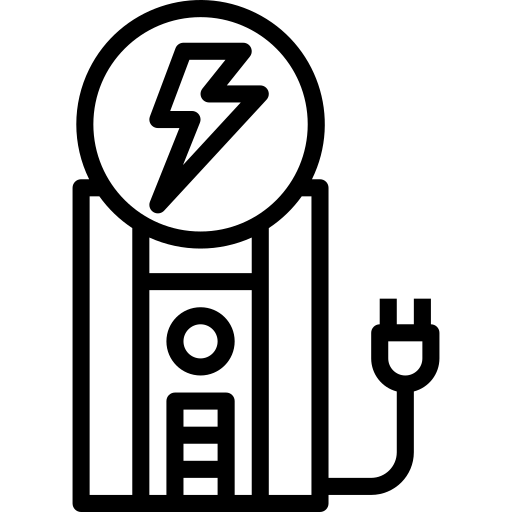
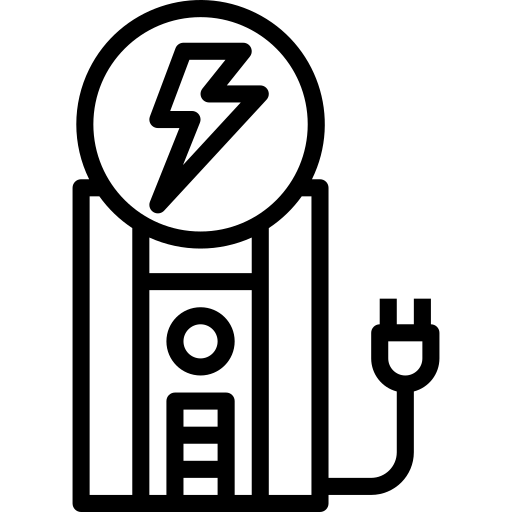
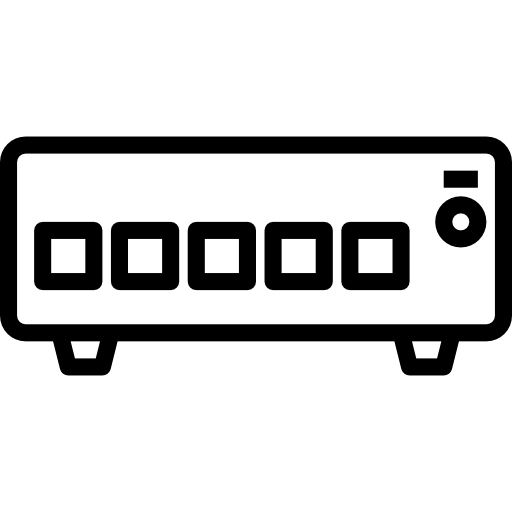
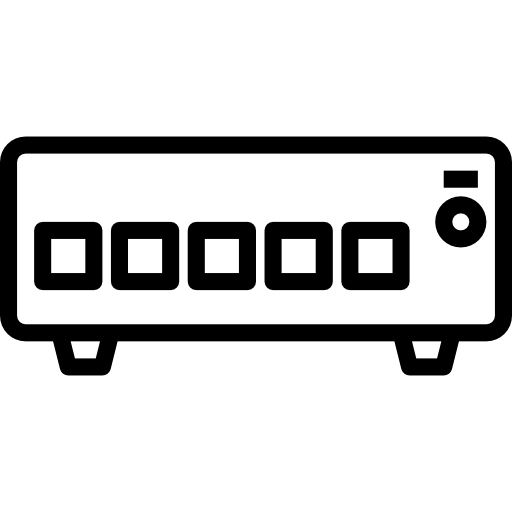
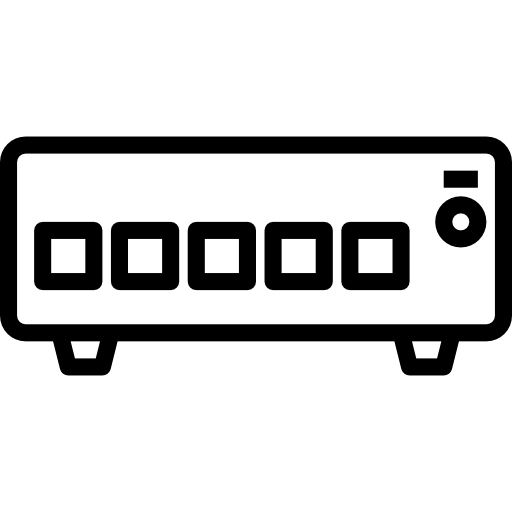
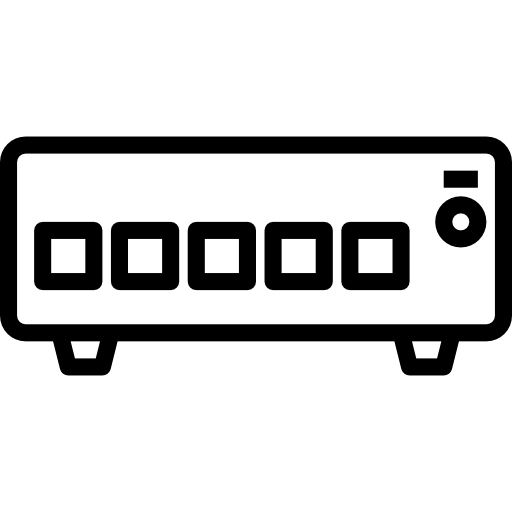
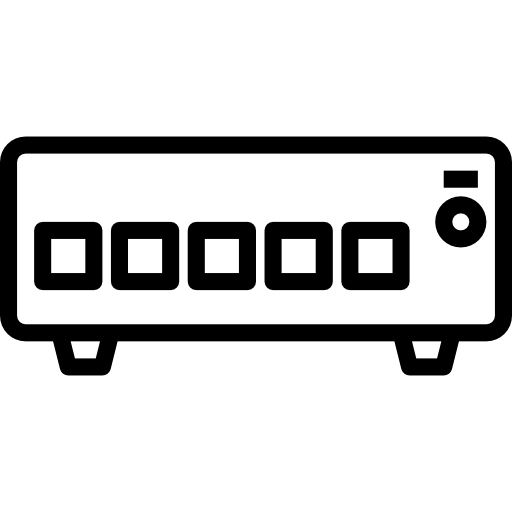
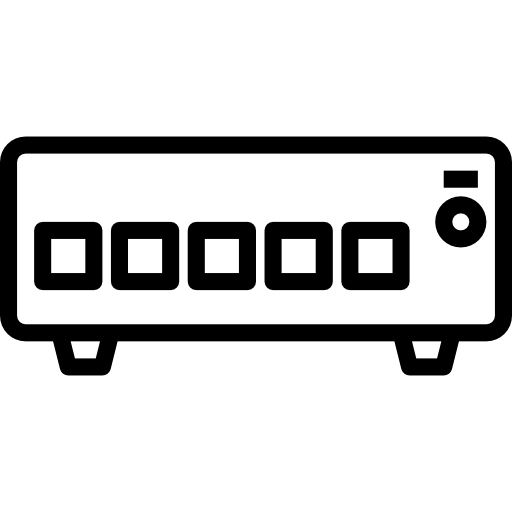

In [72]:
fig.update_layout(
    updatemenus=[
        dict(
         buttons=list([   
            dict(label = 'all instances',
                 method = 'update',
                 args = [{'visible': [True, True, True, True, True, True, True, True, True]},
                         {'title': 'All data'}]),
             
            dict(label = 'switches',
                 method = 'update',
                 args = [{'visible': [True, False, True, False, True, False, True, True, True]},
                         {'title': 'Switches only'}]),
            
             dict(label = 'only unhealthy',
                 method = 'update',
                 args = [{'visible': [False, False, True, True, True, True, False, True, True]},
                         {'title': 'Unhealth devices only'}]), 
             
            dict(label = 'only healthy',
                 method = 'update',
                 args = [{'visible': [True, True, False, False, True, True, True, False, True]},
                         {'title': 'Health devices only'}]),  

            dict(label = 'UPS',
                 method = 'update',
                 args = [{'visible': [False, True, False, True, False, True, True, True, True]},
                         {'title': 'UPS only'}]),
            
            
        ]),
    )]
)


fig.show()